# Google Play Digital Health Apps Analysis

This notebook demonstrates how to use the `google-play-scraper` package to search for digital health apps on the Google Play Store and analyze their reviews. We'll be using pandas and numpy for data manipulation and analysis.

## Setup and Installation

First, let's install the required packages if they're not already installed.

In [1]:
!pip install google-play-scraper pandas numpy matplotlib seaborn wordcloud nltk

  Using cached google_play_scraper-1.2.7-py3-none-any.whl.metadata (50 kB)
Using cached google_play_scraper-1.2.7-py3-none-any.whl (28 kB)


## Importing Libraries

Now, let's import all the necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import time
from tqdm.auto import tqdm
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Google Play Scraper
from google_play_scraper import app, reviews, search, permissions
from google_play_scraper.exceptions import NotFoundError

# Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Setting plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

/Users/seanmacbook/GitHub/healthapp_web_scrapper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seanmacbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/seanmacbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 1: Search for Digital Health Apps

First, we'll search for apps related to "digital health" on the Google Play Store.

In [3]:
# Search for digital health related apps
search_results = search(
    'digital health',
    lang='en',      # Language
    country='us',   # Country
    n_hits=100      # Number of apps to retrieve (maximum 200)
)

# Convert to DataFrame
apps_df = pd.DataFrame(search_results)

# Display basic information
print(f"Found {len(apps_df)} apps related to 'digital health'")
apps_df.head()

Found 30 apps related to 'digital health'


,appId,icon,screenshots,title,score,genre,price,free,currency,video,videoImage,description,descriptionHTML,developer,installs
0,com.ochsner.digitalmedicine,https://play-lh.googleusercontent.com/mh5gRZSZ...,[https://play-lh.googleusercontent.com/_Mn8bW7...,Digital Medicine,4.166666,Health & Fitness,0,True,USD,None,None,The Digital Medicine app simplifies how you ca...,The Digital Medicine app simplifies how you ca...,Ochsner Health System,"5,000+"
1,com.appex.myhealth,https://play-lh.googleusercontent.com/_6O_LPIJ...,[https://play-lh.googleusercontent.com/Y_teNQu...,MyHealth-Digital Health Locker,0.000000,Health & Fitness,0,True,USD,None,None,MyHealth app is a digital health locker that h...,MyHealth app is a digital health locker that h...,Appex Innovation Solutions LLC,"1,000+"
2,com.cogniss.edinburghinnovations.digitalhealth...,https://play-lh.googleusercontent.com/mcX24LM5...,[https://play-lh.googleusercontent.com/PZ39wy9...,Digital Health Portal,NaN,Health & Fitness,0,True,USD,None,None,Edinburgh Innovations is the University of Edi...,Edinburgh Innovations is the University of Edi...,Cogniss,10+
3,com.healthcarecentral.healthly,https://play-lh.googleusercontent.com/9TfbVyZe...,[https://play-lh.googleusercontent.com/mIS_oXu...,HealthLy - Digital Health,4.019608,Medical,0,True,USD,None,None,The BEST NEW health & medication management ap...,The BEST NEW health &amp; medication managemen...,HealthCare Central Co.,"50,000+"
4,com.FlexCare.app,https://play-lh.googleusercontent.com/BR-iVsg2...,[https://play-lh.googleusercontent.com/7lNd5ly...,FlexCare Digital Health,2.000000,Health & Fitness,0,True,USD,None,None,FlexCare is a Digital Health provider offering...,FlexCare is a Digital Health provider offering...,FlexCare. LLC,"1,000+"


Let's check what columns are available and clean up our dataframe.

In [4]:
# Check available columns
print(apps_df.columns.tolist())

# Select and rename columns for better readability
apps_df = apps_df[['appId', 'title', 'score', 'genre', 'price', 'free', 'currency', 'description', 'developer','installs']]

# Convert numeric types
apps_df['score'] = pd.to_numeric(apps_df['score'], errors='coerce')
apps_df['installs'] = pd.to_numeric(apps_df['installs'], errors='coerce')

# Display the updated dataframe
apps_df.head()

['appId', 'icon', 'screenshots', 'title', 'score', 'genre', 'price', 'free', 'currency', 'video', 'videoImage', 'description', 'descriptionHTML', 'developer', 'installs']


,appId,title,score,genre,price,free,currency,description,developer,installs
0,com.ochsner.digitalmedicine,Digital Medicine,4.166666,Health & Fitness,0,True,USD,The Digital Medicine app simplifies how you ca...,Ochsner Health System,NaN
1,com.appex.myhealth,MyHealth-Digital Health Locker,0.000000,Health & Fitness,0,True,USD,MyHealth app is a digital health locker that h...,Appex Innovation Solutions LLC,NaN
2,com.cogniss.edinburghinnovations.digitalhealth...,Digital Health Portal,NaN,Health & Fitness,0,True,USD,Edinburgh Innovations is the University of Edi...,Cogniss,NaN
3,com.healthcarecentral.healthly,HealthLy - Digital Health,4.019608,Medical,0,True,USD,The BEST NEW health & medication management ap...,HealthCare Central Co.,NaN
4,com.FlexCare.app,FlexCare Digital Health,2.000000,Health & Fitness,0,True,USD,FlexCare is a Digital Health provider offering...,FlexCare. LLC,NaN


## Step 2: Explore the App Data

Let's explore the search results with some basic visualizations.

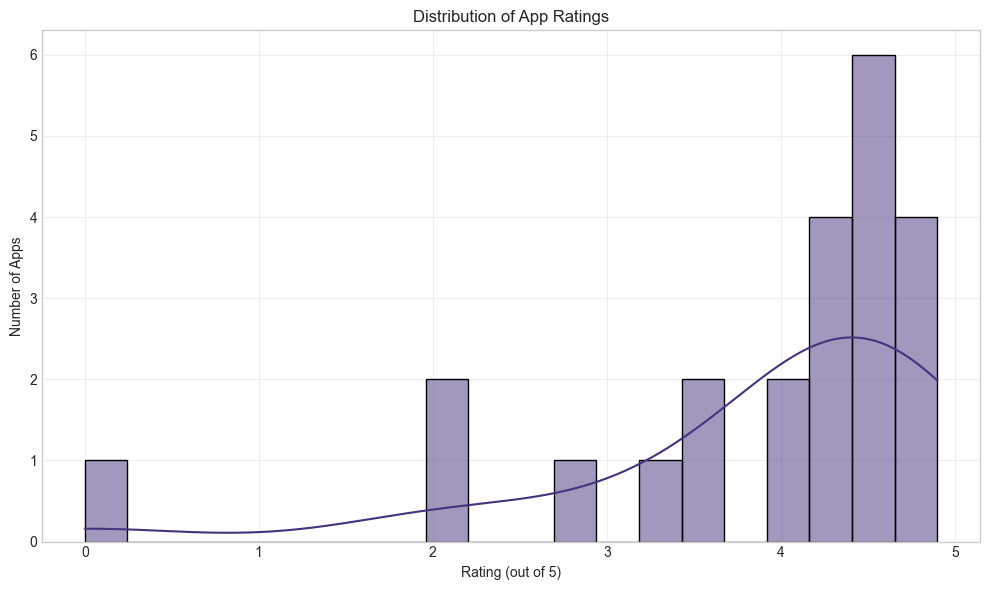

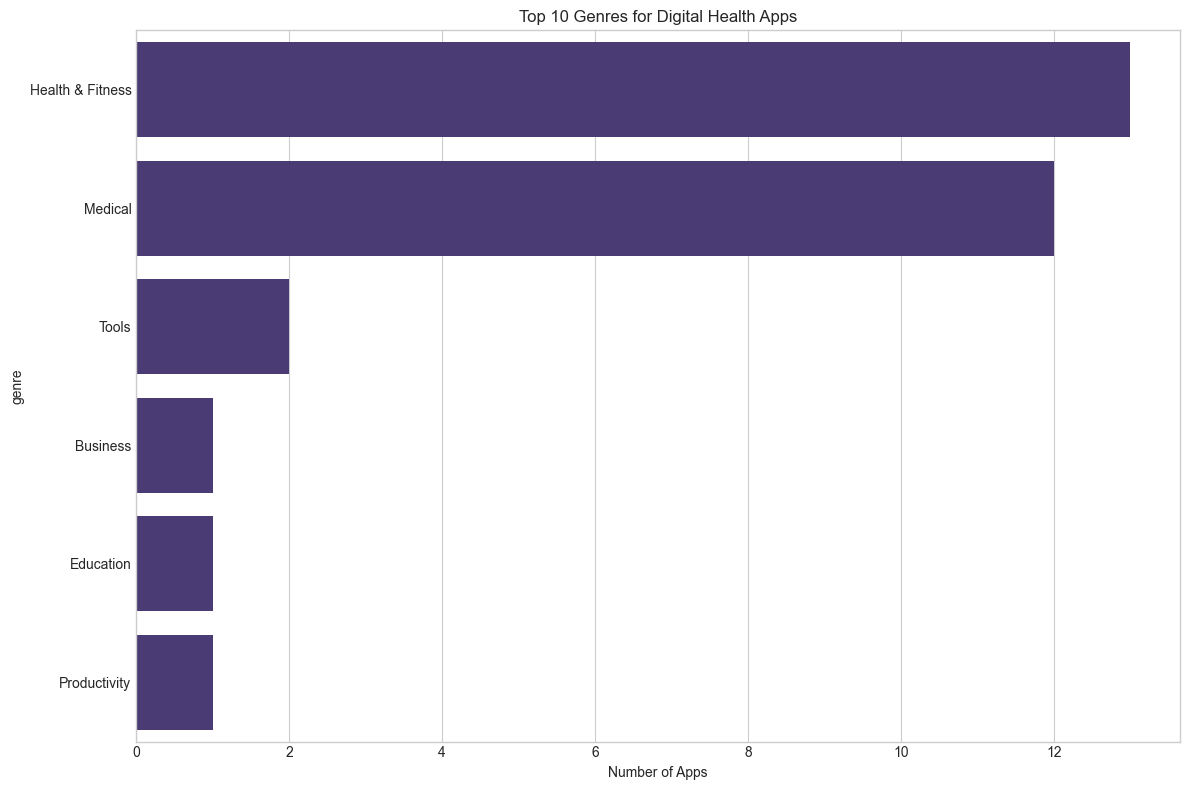

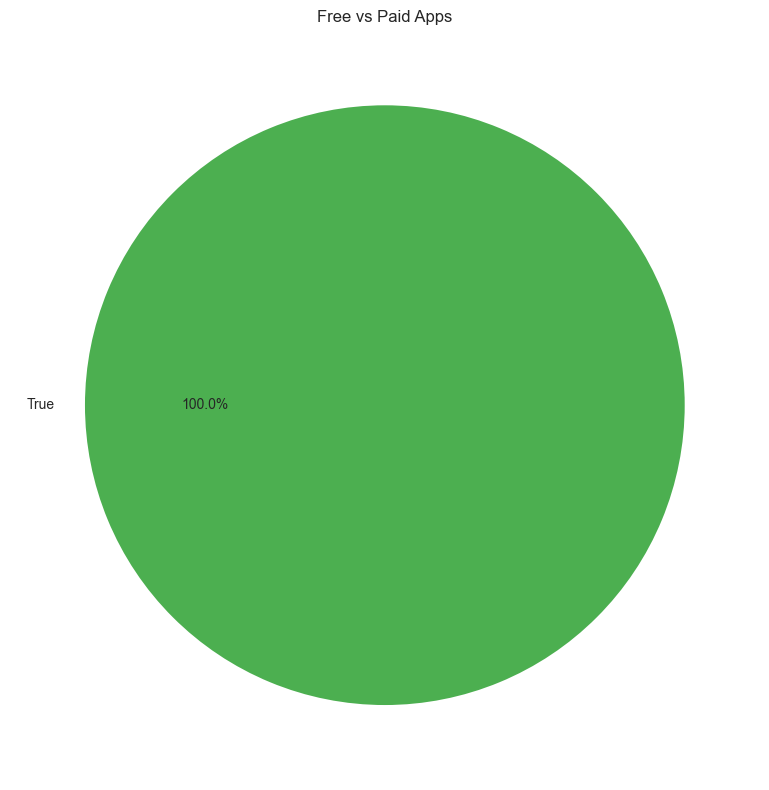

In [5]:
# Distribution of app ratings
plt.figure(figsize=(10, 6))
sns.histplot(apps_df['score'].dropna(), bins=20, kde=True)
plt.title('Distribution of App Ratings')
plt.xlabel('Rating (out of 5)')
plt.ylabel('Number of Apps')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Top genres
plt.figure(figsize=(12, 8))
genre_counts = apps_df['genre'].value_counts().head(10)
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Top 10 Genres for Digital Health Apps')
plt.xlabel('Number of Apps')
plt.tight_layout()
plt.show()

# Free vs Paid apps
plt.figure(figsize=(8, 8))
free_counts = apps_df['free'].value_counts()
plt.pie(free_counts, labels=free_counts.index, autopct='%1.1f%%', colors=['#4CAF50', '#2196F3', '#FFC107', '#9C27B0'][:len(free_counts)])
plt.title('Free vs Paid Apps')
plt.tight_layout()
plt.show()

Let's look at the top 10 apps based on user ratings and install counts.

In [6]:
# Top rated apps (minimum 1000 installs to filter out new apps with few ratings)
top_rated = apps_df[apps_df['installs'] >= 1000].sort_values('score', ascending=False).head(10)
print("Top 10 Rated Digital Health Apps:")
top_rated[['title', 'developer', 'score', 'installs', 'genre']]

# Most installed apps
most_installed = apps_df.sort_values('installs', ascending=False).head(10)
print("\nTop 10 Most Installed Digital Health Apps:")
most_installed[['title', 'developer', 'score', 'installs', 'genre']]

Top 10 Rated Digital Health Apps:

Top 10 Most Installed Digital Health Apps:


,title,developer,score,installs,genre
0,Digital Medicine,Ochsner Health System,4.166666,NaN,Health & Fitness
1,MyHealth-Digital Health Locker,Appex Innovation Solutions LLC,0.000000,NaN,Health & Fitness
2,Digital Health Portal,Cogniss,NaN,NaN,Health & Fitness
3,HealthLy - Digital Health,HealthCare Central Co.,4.019608,NaN,Medical
4,FlexCare Digital Health,FlexCare. LLC,2.000000,NaN,Health & Fitness
5,Calcium Digital Health AI,Calcium LLC,3.372549,NaN,Medical
6,DIGITAL HEALTH FESTIVAL 2025,Digital Health Festival,NaN,NaN,Business
7,Digital Healthcare Solutions,Digital Healthcare Solutions LLC,2.142857,NaN,Health & Fitness
8,MyChart,Epic Systems Corporation,4.564499,NaN,Medical
9,Academy of Digital Health,Digital Health Associates,NaN,NaN,Education


## Step 3: Get Detailed Information for Each App

Now, let's get more detailed information about each app. This step is optional if you only need the review data.

In [7]:
import pandas as pd
import time
from tqdm.auto import tqdm  # Recommended for notebooks
from google_play_scraper import app
from google_play_scraper.exceptions import NotFoundError

def get_app_details(app_id):
    try:
        details = app(app_id, lang='en', country='us')
        return details
    except NotFoundError:
        print(f"App not found: {app_id}")
        return None
    except Exception as e:
        print(f"Error getting details for {app_id}: {e}")
        return None

# Make sure most_installed is defined
# Get details for the top 10 apps by installs (as a sample)
app_details_list = []
for app_id in tqdm(most_installed['appId']):
    details = get_app_details(app_id)
    if details:
        app_details_list.append(details)
    time.sleep(2)  # Delay to avoid hitting API limits

# Convert to DataFrame
details_df = pd.DataFrame(app_details_list)
details_df.head()


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


,title,description,descriptionHTML,summary,installs,minInstalls,realInstalls,score,ratings,reviews,...,contentRatingDescription,adSupported,containsAds,released,lastUpdatedOn,updated,version,comments,appId,url
0,Digital Medicine,The Digital Medicine app simplifies how you ca...,The Digital Medicine app simplifies how you ca...,Manage your health from home,"5,000+",5000,9645,4.166666,66.0,28.0,...,None,False,False,"Aug 22, 2023","Mar 31, 2025",1743453661,4.2.2(4),[],com.ochsner.digitalmedicine,https://play.google.com/store/apps/details?id=...
1,MyHealth-Digital Health Locker,MyHealth app is a digital health locker that h...,MyHealth app is a digital health locker that h...,"MyHealth, Medical Records, ABHA","1,000+",1000,1513,0.000000,0.0,0.0,...,None,False,False,"Mar 24, 2023","Mar 26, 2025",1742998986,2.3.44,[],com.appex.myhealth,https://play.google.com/store/apps/details?id=...
2,Digital Health Portal,Edinburgh Innovations is the University of Edi...,Edinburgh Innovations is the University of Edi...,Digital Health projects by Edinburgh Universit...,10+,10,32,NaN,NaN,NaN,...,None,False,False,"May 5, 2024","May 5, 2024",1714954452,1.109.0,[],com.cogniss.edinburghinnovations.digitalhealth...,https://play.google.com/store/apps/details?id=...
3,HealthLy - Digital Health,The BEST NEW health & medication management ap...,The BEST NEW health &amp; medication managemen...,Pill & Injection Reminder with Medication Mana...,"50,000+",50000,88481,4.019608,222.0,8.0,...,None,False,False,"Jul 14, 2021","Oct 12, 2024",1728756472,2.1.0,[],com.healthcarecentral.healthly,https://play.google.com/store/apps/details?id=...
4,FlexCare Digital Health,FlexCare is a Digital Health provider offering...,FlexCare is a Digital Health provider offering...,24/7 Access to Digital Health Programs,"1,000+",1000,3008,2.000000,12.0,9.0,...,None,False,False,"Jan 31, 2021","Aug 16, 2024",1723812754,1.2.1,[],com.FlexCare.app,https://play.google.com/store/apps/details?id=...


In [8]:
# Select relevant columns
if not details_df.empty:
    selected_details = details_df[['appId', 'title', 'description', 'summary', 'installs', 'ratings', 
                                 'reviews', 'version', 'contentRating', 'adSupported', 
                                 'containsAds', 'released', 'updated']]
    display(selected_details.head(5))
else:
    print("No app details were retrieved successfully.")

,appId,title,description,summary,installs,ratings,reviews,version,contentRating,adSupported,containsAds,released,updated
0,com.ochsner.digitalmedicine,Digital Medicine,The Digital Medicine app simplifies how you ca...,Manage your health from home,"5,000+",66.0,28.0,4.2.2(4),Everyone,False,False,"Aug 22, 2023",1743453661
1,com.appex.myhealth,MyHealth-Digital Health Locker,MyHealth app is a digital health locker that h...,"MyHealth, Medical Records, ABHA","1,000+",0.0,0.0,2.3.44,Everyone,False,False,"Mar 24, 2023",1742998986
2,com.cogniss.edinburghinnovations.digitalhealth...,Digital Health Portal,Edinburgh Innovations is the University of Edi...,Digital Health projects by Edinburgh Universit...,10+,NaN,NaN,1.109.0,Everyone,False,False,"May 5, 2024",1714954452
3,com.healthcarecentral.healthly,HealthLy - Digital Health,The BEST NEW health & medication management ap...,Pill & Injection Reminder with Medication Mana...,"50,000+",222.0,8.0,2.1.0,Everyone,False,False,"Jul 14, 2021",1728756472
4,com.FlexCare.app,FlexCare Digital Health,FlexCare is a Digital Health provider offering...,24/7 Access to Digital Health Programs,"1,000+",12.0,9.0,1.2.1,Everyone,False,False,"Jan 31, 2021",1723812754


## Step 4: Scrape Reviews for Each App

Now, let's scrape reviews for each of the top 20 apps based on installations. We'll limit the number of reviews to 100 per app for this example, but you can increase this as needed.

In [9]:
def get_reviews(app_id, count=1000, lang='en', country='us'):
    """Get reviews for a specific app"""
    try:
        # Initialize variables for pagination
        result = []
        continuation_token = None
        previous_result_len = 0
        
        # Paginate through results until we reach the desired count
        while len(result) < count:
            # Calculate how many reviews to request in this batch
            batch_size = min(1000, count - len(result))  # Max 1000 per request
            
            # Request reviews with timeout
            reviews_result, continuation_token = reviews(
                app_id,
                lang=lang,
                country=country,
                count=batch_size,
                continuation_token=continuation_token
            )
            
            # Append results and check if we need to continue
            result.extend(reviews_result)
            
            # Safety check: if no new reviews were added, break
            if len(result) == previous_result_len or continuation_token is None:
                break
            
            previous_result_len = len(result)
                
        return pd.DataFrame(result)
    except Exception as e:
        print(f"Error getting reviews for {app_id}: {str(e)}")
        return pd.DataFrame()

# Select top 20 apps by installation count
top_apps = apps_df.sort_values('installs', ascending=False).head(20)
all_reviews_df = pd.DataFrame()

# Get reviews for each app
for idx, app_row in tqdm(top_apps.iterrows(), total=len(top_apps)):
    app_id = app_row['appId']
    app_title = app_row['title']
    
    print(f"Getting reviews for {app_title} ({app_id})")
    
    # Get reviews for this app (1000 reviews per app for this example)
    app_reviews = get_reviews(app_id, 1000)
    
    if not app_reviews.empty:
        # Add app information to each review
        app_reviews['app_id'] = app_id
        app_reviews['app_title'] = app_title
        
        # Append to the main dataframe
        all_reviews_df = pd.concat([all_reviews_df, app_reviews], ignore_index=True)
    
    # Delay to avoid hitting API limits
    time.sleep(2)

print(f"Total reviews collected: {len(all_reviews_df)}")

  0%|          | 0/20 [00:00<?, ?it/s]

Getting reviews for Digital Medicine (com.ochsner.digitalmedicine)


  5%|▌         | 1/20 [00:03<01:06,  3.51s/it]

Getting reviews for MyHealth-Digital Health Locker (com.appex.myhealth)


 10%|█         | 2/20 [00:06<00:52,  2.93s/it]

Getting reviews for Digital Health Portal (com.cogniss.edinburghinnovations.digitalhealthportal)


 15%|█▌        | 3/20 [00:08<00:44,  2.63s/it]

Getting reviews for HealthLy - Digital Health (com.healthcarecentral.healthly)


 20%|██        | 4/20 [00:10<00:40,  2.56s/it]

Getting reviews for FlexCare Digital Health (com.FlexCare.app)


 25%|██▌       | 5/20 [00:13<00:40,  2.67s/it]

Getting reviews for Calcium Digital Health AI (com.myhealthchampion.mobile)


 30%|███       | 6/20 [00:16<00:36,  2.58s/it]

Getting reviews for DIGITAL HEALTH FESTIVAL 2025 (events.grip.dhf1007)


 35%|███▌      | 7/20 [00:18<00:32,  2.53s/it]

Getting reviews for Digital Healthcare Solutions (com.yourdhs.app)


 40%|████      | 8/20 [00:20<00:29,  2.45s/it]

Getting reviews for MyChart (epic.mychart.android)


 45%|████▌     | 9/20 [00:23<00:29,  2.66s/it]

Getting reviews for Academy of Digital Health (com.dha.academy)


 50%|█████     | 10/20 [00:26<00:25,  2.57s/it]

Getting reviews for Digital Health & Medication (com.bapelkesks.digitalmedication)


 55%|█████▌    | 11/20 [00:28<00:22,  2.49s/it]

Getting reviews for Human Health Tracker (health.human.app)


 60%|██████    | 12/20 [00:30<00:19,  2.47s/it]

Getting reviews for Digital Doctor (health.vivica.digitaldoctor)


 65%|██████▌   | 13/20 [00:33<00:17,  2.43s/it]

Getting reviews for Well Digital (co.well.wellapp)


 70%|███████   | 14/20 [00:36<00:15,  2.52s/it]

Getting reviews for Teladoc Health (com.teladoc.members)


 75%|███████▌  | 15/20 [00:39<00:13,  2.68s/it]

Getting reviews for Ada – check your health (com.ada.app)


 80%|████████  | 16/20 [00:42<00:11,  2.78s/it]

Getting reviews for K Health | 24/7 Virtual Care (ai.kanghealth)


 85%|████████▌ | 17/20 [00:45<00:08,  2.91s/it]

Getting reviews for Digital salud (com.meddi.health)


 90%|█████████ | 18/20 [00:47<00:05,  2.79s/it]

Getting reviews for Personify Health (com.virginpulse.virginpulse)


 95%|█████████▌| 19/20 [00:50<00:02,  2.81s/it]

Getting reviews for HealtheLife (com.cerner.iris.play)


100%|██████████| 20/20 [00:53<00:00,  2.69s/it]

Total reviews collected: 6612


Let's examine the structure of the reviews data.

Available columns: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion', 'app_id', 'app_title', 'year', 'month', 'yearmonth', 'review_length', 'sentiment']

Basic Statistics:
Total Reviews: 6612
Unique Apps: 15
Average Score: 3.37


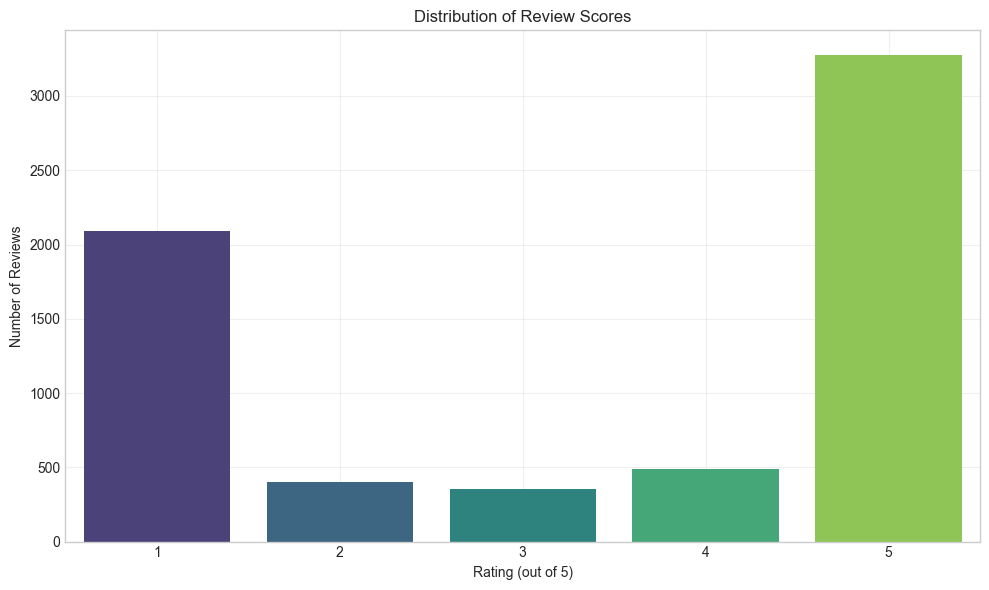

In [15]:
# Display the first few reviews
all_reviews_df.head()

# Check available columns
print("Available columns:", all_reviews_df.columns.tolist())

# Basic statistics
print("\nBasic Statistics:")
print(f"Total Reviews: {len(all_reviews_df)}")
print(f"Unique Apps: {all_reviews_df['app_title'].nunique()}")
print(f"Average Score: {all_reviews_df['score'].mean():.2f}")

# Distribution of review scores
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=all_reviews_df, palette='viridis')
plt.title('Distribution of Review Scores')
plt.xlabel('Rating (out of 5)')
plt.ylabel('Number of Reviews')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 5: Data Preprocessing and Analysis

Now, let's preprocess the review data and perform some analysis.

In [16]:
# Convert review date to datetime
all_reviews_df['at'] = pd.to_datetime(all_reviews_df['at'])

# Extract year and month for time-based analysis
all_reviews_df['year'] = all_reviews_df['at'].dt.year
all_reviews_df['month'] = all_reviews_df['at'].dt.month

# Create a yearmonth column for easier grouping
all_reviews_df['yearmonth'] = all_reviews_df['at'].dt.strftime('%Y-%m')

# Calculate review length
all_reviews_df['review_length'] = all_reviews_df['content'].fillna('').apply(len)

# Function to classify sentiment based on score
def classify_sentiment(score):
    if score <= 2:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

all_reviews_df['sentiment'] = all_reviews_df['score'].apply(classify_sentiment)

# Display the processed data
all_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app_id,app_title,year,month,yearmonth,review_length,sentiment
0,233306d7-3824-4bee-ad33-75503e313e6b,Sherry Northington,https://play-lh.googleusercontent.com/a/ACg8oc...,App doesn't properly graph readings. It puts a...,1,0,4.2.2(4),2025-04-05 22:13:01,None,NaT,4.2.2(4),com.ochsner.digitalmedicine,Digital Medicine,2025,4,2025-04,496,Negative
1,d9d27d40-472b-4627-9073-fe9b8179e8f5,Teresa Weimer,https://play-lh.googleusercontent.com/a-/ALV-U...,👍 good,4,0,4.2.1(5),2025-04-02 15:34:02,None,NaT,4.2.1(5),com.ochsner.digitalmedicine,Digital Medicine,2025,4,2025-04,6,Positive
2,21086650-4b58-40bc-a4f2-62c1a3a023bc,Josiclyn Ortego,https://play-lh.googleusercontent.com/a/ACg8oc...,love it,5,0,4.2.1(5),2025-03-31 11:19:57,None,NaT,4.2.1(5),com.ochsner.digitalmedicine,Digital Medicine,2025,3,2025-03,7,Positive
3,cc0b6f1e-7c59-44fe-9ff5-07eb946e8be9,Mary Jenkins,https://play-lh.googleusercontent.com/a/ACg8oc...,Great,5,0,4.1.0(6),2025-03-12 15:57:13,None,NaT,4.1.0(6),com.ochsner.digitalmedicine,Digital Medicine,2025,3,2025-03,5,Positive
4,8302a08d-3830-419a-b862-7b8892b3e9b0,John Ware,https://play-lh.googleusercontent.com/a/ACg8oc...,Works as expected.,5,0,None,2025-03-09 10:44:07,None,NaT,None,com.ochsner.digitalmedicine,Digital Medicine,2025,3,2025-03,18,Positive


## Step 6: Review Analysis by App

Let's look at the average ratings and review sentiments for each app.

In [17]:
# Group by app and calculate average ratings
app_ratings = all_reviews_df.groupby('app_title')['score'].agg(['count', 'mean']).reset_index()
app_ratings.columns = ['app_title', 'review_count', 'average_rating']
app_ratings = app_ratings.sort_values('review_count', ascending=False)

# Display app ratings
app_ratings

,app_title,review_count,average_rating
0,Ada – check your health,1000,4.515000
7,HealtheLife,1000,2.296000
9,K Health | 24/7 Virtual Care,1000,2.811000
10,MyChart,1000,4.296000
12,Personify Health,1000,1.970000
13,Teladoc Health,1000,3.913000
14,Well Digital,240,4.408333
11,MyHealth-Digital Health Locker,132,4.931818
8,Human Health Tracker,110,3.600000
1,Calcium Digital Health AI,64,2.828125


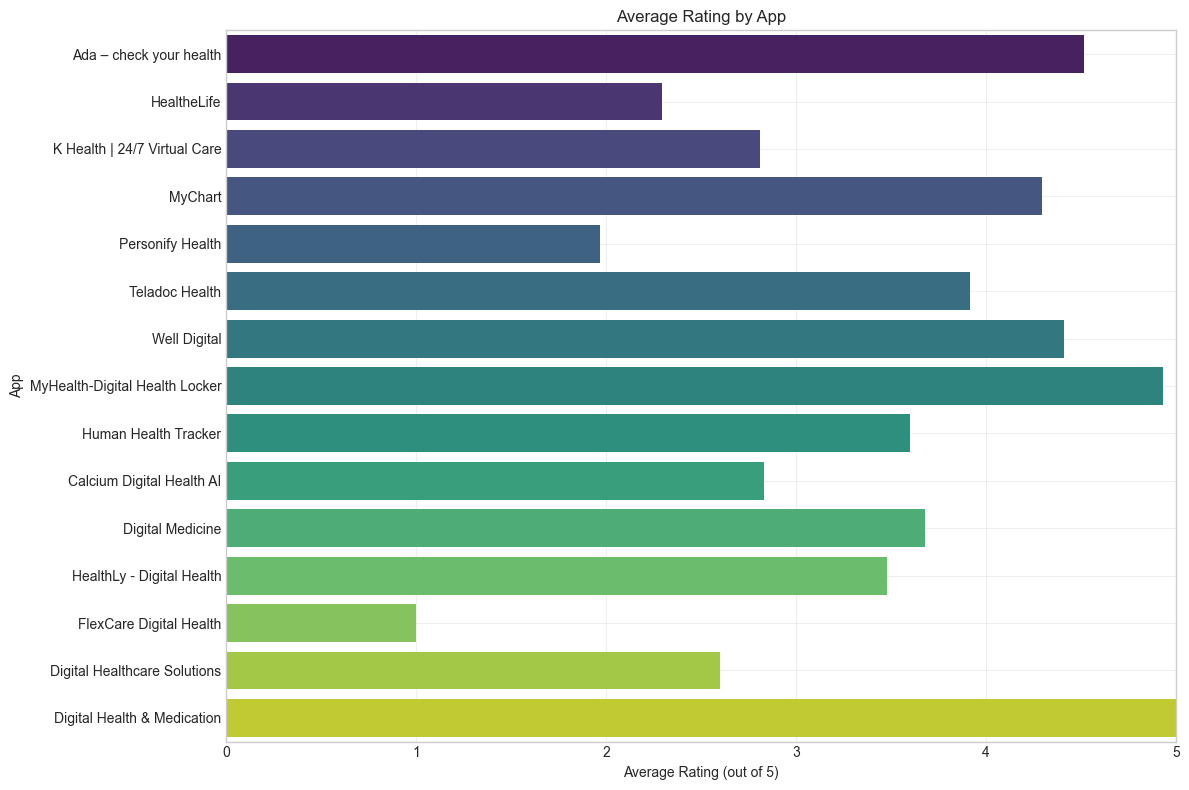

<Figure size 1400x1000 with 0 Axes>

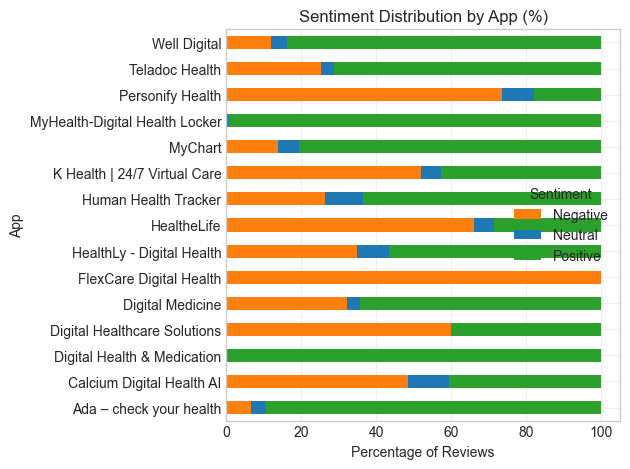

In [18]:
# Visualize app ratings
plt.figure(figsize=(12, 8))
sns.barplot(y='app_title', x='average_rating', data=app_ratings, palette='viridis')
plt.title('Average Rating by App')
plt.xlabel('Average Rating (out of 5)')
plt.ylabel('App')
plt.xlim(0, 5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Review sentiment distribution by app
sentiment_by_app = all_reviews_df.groupby(['app_title', 'sentiment']).size().unstack().fillna(0)
sentiment_by_app_pct = sentiment_by_app.div(sentiment_by_app.sum(axis=1), axis=0) * 100

# Plot sentiment distribution
plt.figure(figsize=(14, 10))
sentiment_by_app_pct.plot(kind='barh', stacked=True, 
                          color=['#ff7f0e', '#1f77b4', '#2ca02c'])
plt.title('Sentiment Distribution by App (%)')
plt.xlabel('Percentage of Reviews')
plt.ylabel('App')
plt.grid(True, alpha=0.3)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

## Step 7: Review Content Analysis

Let's analyze the content of the reviews to identify common themes and keywords.

In [21]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/seanmacbook/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [22]:
# Function to clean text data
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        return ' '.join(tokens)
    return ''

# Clean review content
all_reviews_df['clean_content'] = all_reviews_df['content'].fillna('').apply(clean_text)

# Function to create wordcloud
def create_wordcloud(text_series, title):
    # Combine all text
    text = ' '.join(text_series.tolist())
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         max_words=100, contour_width=3, contour_color='steelblue')
    wordcloud.generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

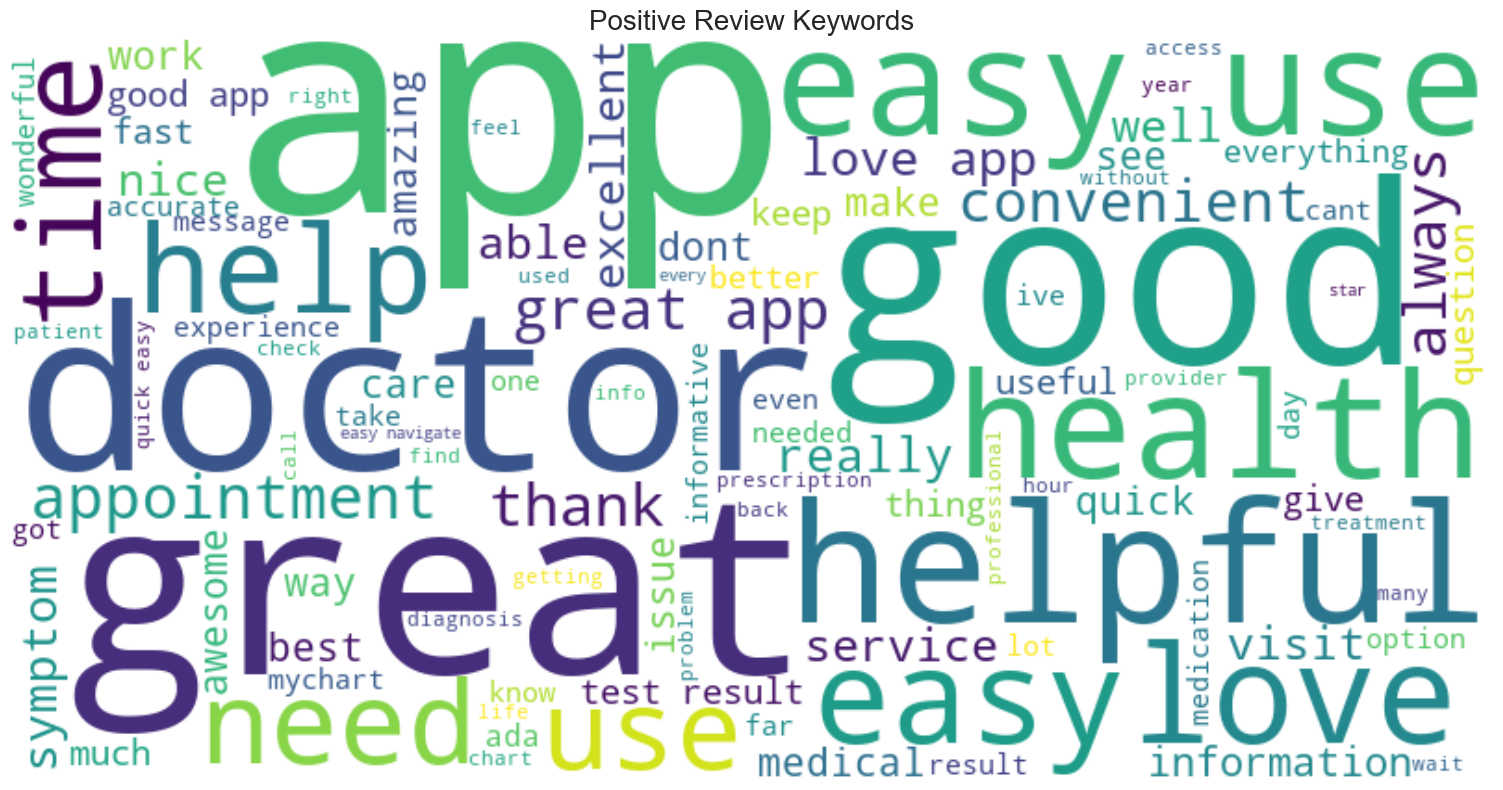

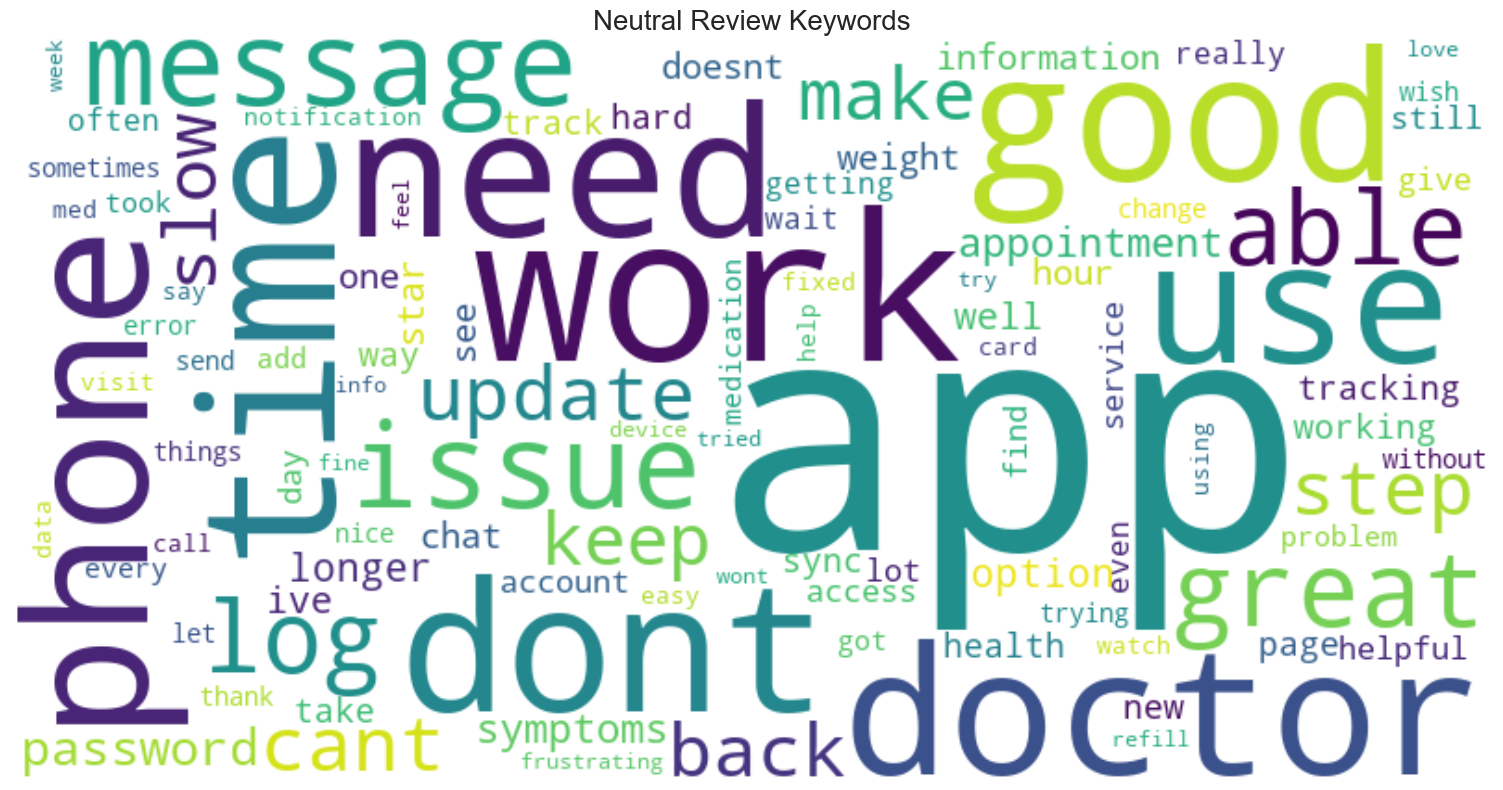

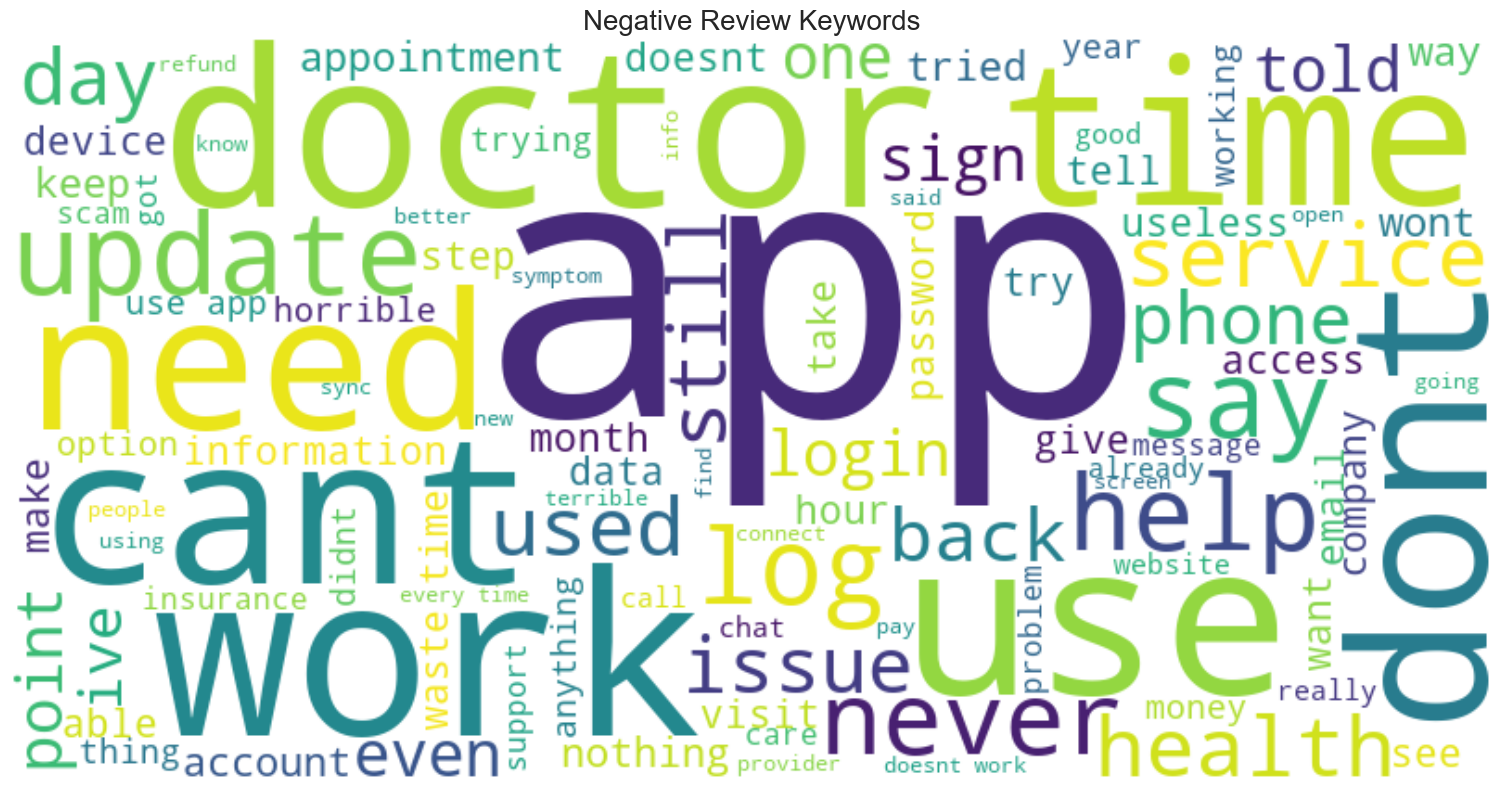

In [23]:
# Create wordclouds by sentiment
for sentiment in ['Positive', 'Neutral', 'Negative']:
    sentiment_reviews = all_reviews_df[all_reviews_df['sentiment'] == sentiment]
    if not sentiment_reviews.empty:
        create_wordcloud(sentiment_reviews['clean_content'], f'{sentiment} Review Keywords')

## Step 8: Temporal Analysis

Let's analyze how reviews and ratings change over time.

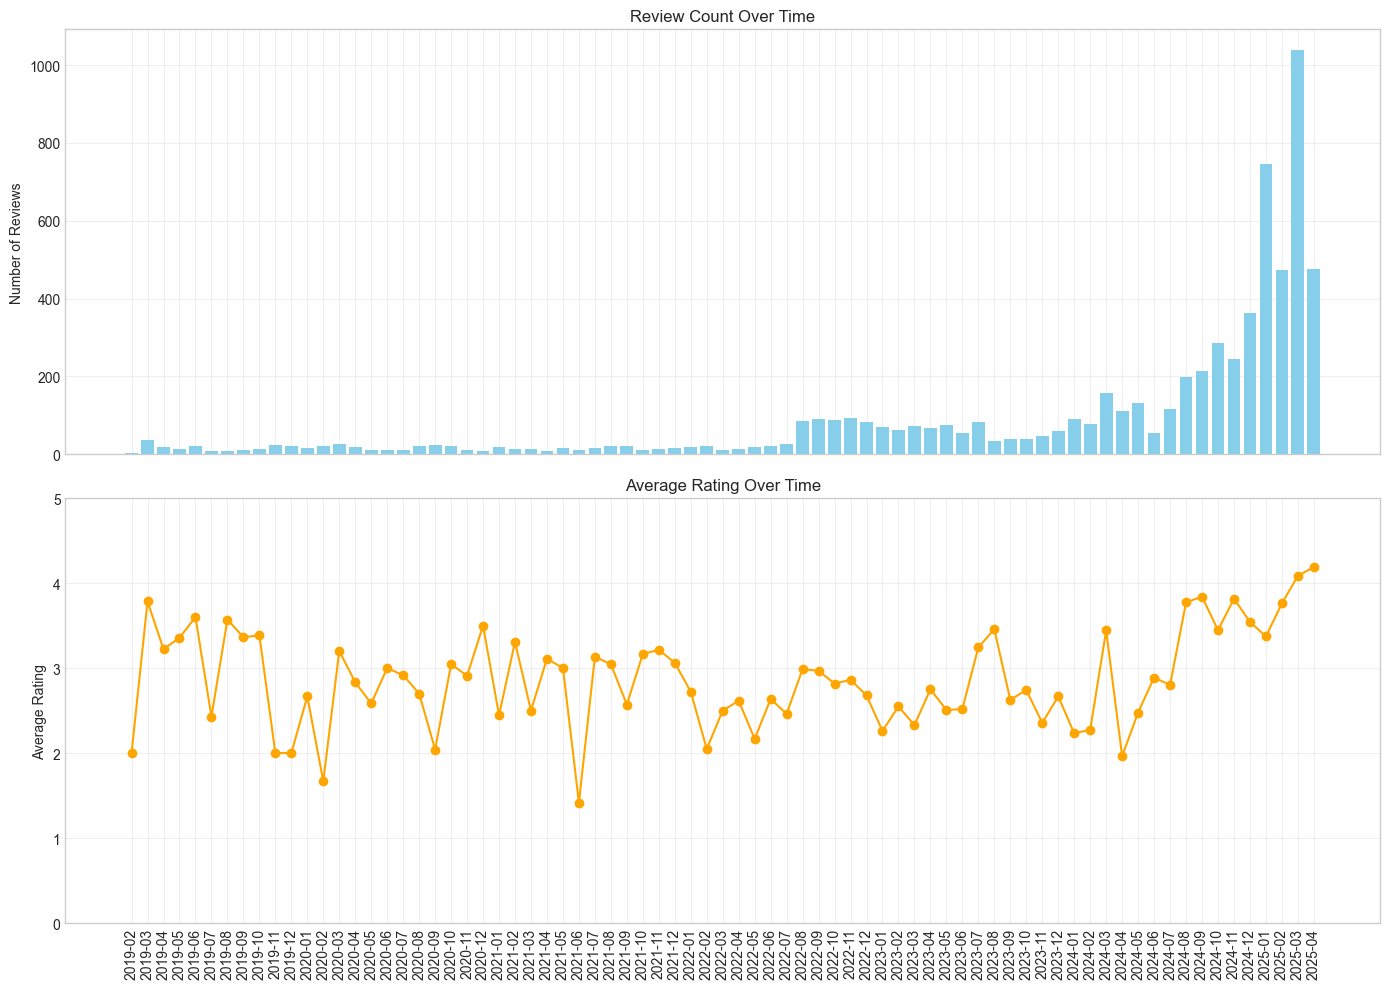

In [24]:
# Group by year and month
time_analysis = all_reviews_df.groupby('yearmonth').agg({
    'score': ['count', 'mean'],
    'review_length': 'mean'
}).reset_index()

time_analysis.columns = ['yearmonth', 'review_count', 'average_rating', 'average_length']
time_analysis = time_analysis.sort_values('yearmonth')

# Plot temporal trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Review count over time
ax1.bar(time_analysis['yearmonth'], time_analysis['review_count'], color='skyblue')
ax1.set_title('Review Count Over Time')
ax1.set_ylabel('Number of Reviews')
ax1.grid(True, alpha=0.3)

# Average rating over time
ax2.plot(time_analysis['yearmonth'], time_analysis['average_rating'], marker='o', linestyle='-', color='orange')
ax2.set_title('Average Rating Over Time')
ax2.set_ylabel('Average Rating')
ax2.set_ylim(0, 5)
ax2.grid(True, alpha=0.3)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Step 9: Export the Data

Finally, let's export our datasets for future use.

In [29]:
# Export app list
apps_df.to_csv('../data/interim/google_play_digital_health_apps.csv', index=False)

# Export all reviews
all_reviews_df.to_csv('../data/interim/google_play_digital_health_apps_reviews.csv', index=False)

print("Data exported successfully!")

Data exported successfully!


## Step 10: Conclusion and Next Steps

In this notebook, we successfully:
1. Searched for digital health apps on the Google Play Store
2. Collected basic information about these apps
3. Retrieved detailed data for top apps by installation count
4. Scraped reviews for the top 20 apps
5. Analyzed review scores, sentiments, and content
6. Performed temporal analysis of reviews
7. Exported the data for future analysis

### Potential Next Steps

- Implement more advanced natural language processing techniques for sentiment analysis
- Cluster apps by features mentioned in descriptions
- Compare competitors in specific categories
- Build predictive models for app success factors
- Create interactive dashboards for ongoing monitoring
- Analyze update frequency and its impact on ratings